In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA

# Test data preparation

In [72]:
df = pd.read_csv('C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/datatestprepared.csv')
df["Weekend"]=df["Weekend"].map(lambda x: 1 if x=="yes" else 0)

test_features=df.drop(columns="Occupancy")

test_target=df["Occupancy"]

In [73]:
test_target.mean()

0.2432954820004832

# Prepare  training data

In [74]:
data=pd.read_csv("C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/trainingDataAfterDataUnderstanding.csv")
data["Weekend"]=data["Weekend"].map(lambda x: 1 if x=="yes" else 0)

In [75]:
data_x=data.drop(columns="Occupancy")

data_y=data["Occupancy"]

from sklearn.preprocessing import StandardScaler

data_x = pd.DataFrame((StandardScaler().fit_transform(data_x.select_dtypes(include=["int64", "float"]))), 
                      columns=(data_x.select_dtypes(include=["int64", "float"])).columns)

print('Initial dataset shape %s' % Counter(data_y))
print('Share of Occupieds %s' % round(data.Occupancy.mean(),2))
print("\n")

Initial dataset shape Counter({0: 6414, 1: 1729})
Share of Occupieds 0.21




No handles with labels found to put in legend.


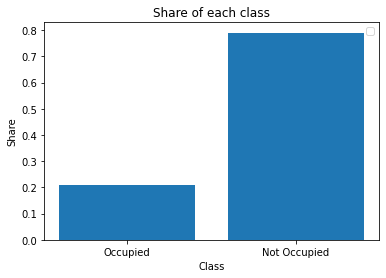

In [76]:
labels=["Occupied", "Not Occupied"]
shares=[round(data.Occupancy.mean(),2), 1-round(data.Occupancy.mean(),2)]


x = np.arange(2)

fig, ax = plt.subplots()
ax.bar(x, shares)
ax.set_ylabel('Share')
ax.set_xlabel('Class')
ax.set_title('Share of each class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.set_xlabel('Class', fontsize = 15)
# ax.set_ylabel('Share', fontsize = 15)
# ax.set_title('Share of each class', fontsize = 20)

# Make imbalance and partition

In [77]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy={0:43225,1:1729}, random_state=42)
# data_x, data_y = sm.fit_resample(data_x, data_y)

In [78]:
rows2remove = np.random.choice(data[data["Occupancy"] == 1].index, 1729 - 267, replace=False)

data_x=np.array(pd.DataFrame(data_x).drop(index=rows2remove, axis=0))
data_y=(np.array(pd.DataFrame(data_y).drop(index=rows2remove, axis=0))).flatten()

In [79]:
from sklearn.model_selection import train_test_split, cross_val_score 

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1, random_state=100, stratify=data_y)

In [80]:
print('Partitioned dataset %s' % Counter(y_train))
print('Share of Occupieds %s' % round(y_train.mean(),4))
print("\n")

Partitioned dataset Counter({0: 5772, 1: 240})
Share of Occupieds 0.0399




# PCA with unbalanced data

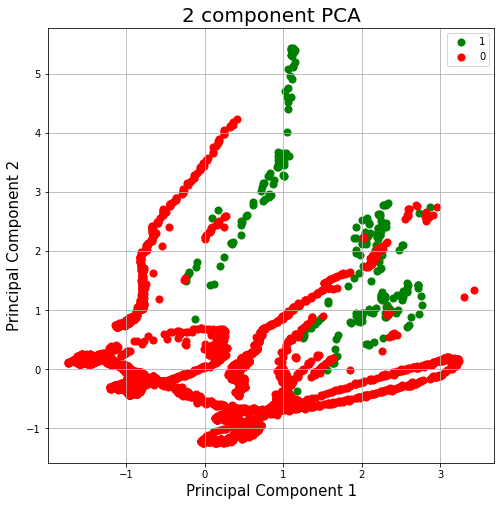

In [81]:
pca = PCA(n_components=2)
# pca.fit(X_train)
# X_pca = pca.transform(X_train)

# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
# plt.show()


filtered_data=pca.fit_transform(X_train)

principalDf = pd.DataFrame(data = filtered_data, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame(y_train, columns=["Occupancy"])], axis = 1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1,0]
colors = ['g', 'r']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Occupancy'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Decision Tree trained with Unbalanced data

In [82]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

Accuracy 0.8561649351695256
F1-score [0.89499059 0.77178635]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      9396
           1       0.63      1.00      0.77      3021

    accuracy                           0.86     12417
   macro avg       0.81      0.90      0.83     12417
weighted avg       0.91      0.86      0.87     12417



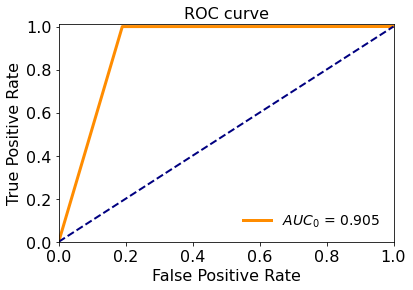

In [96]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

y_score = clf.predict_proba(test_features)
fpr0, tpr0, _ = roc_curve(test_target, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [97]:
# (pd.concat([pd.DataFrame(test_target), pd.DataFrame(y_pred, columns=["prediction"])], axis=1)
# ).to_csv("C:/Users/xhuli/Desktop/classification_unbalanced.csv", index=False)

# Undersampling

#### RandomUnderSampler

In [98]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Partitioned and Undersampled dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s' % round(y_res.mean(),2))
print("\n")

Partitioned and Undersampled dataset Counter({0: 240, 1: 240})
Share of Occupieds 0.5




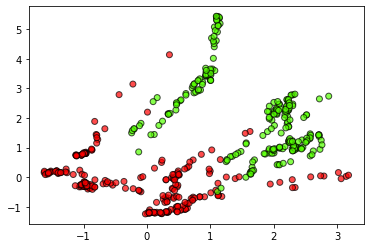

In [99]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.8561649351695256
F1-score [0.89499059 0.77178635]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      9396
           1       0.63      1.00      0.77      3021

    accuracy                           0.86     12417
   macro avg       0.81      0.90      0.83     12417
weighted avg       0.91      0.86      0.87     12417



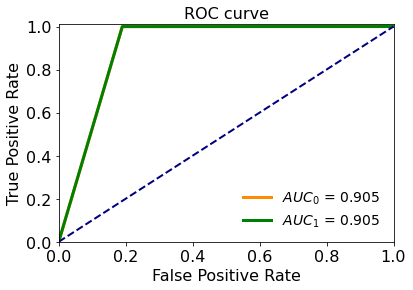

In [100]:
clf_rus = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf_rus.fit(X_res, y_res)

y_pred = clf_rus.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

y_score = clf_rus.predict_proba(test_features)
fpr, tpr, _ = roc_curve(test_target, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### CondensedNearestNeighbour

In [108]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42)
X_res, y_res = cnn.fit_resample(X_train, y_train)

print('Partitioned and CNN Undersampled dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s\n' % round(y_res.mean(),2))

Partitioned and CNN Undersampled dataset Counter({1: 240, 0: 35})
Share of Occupieds 0.87



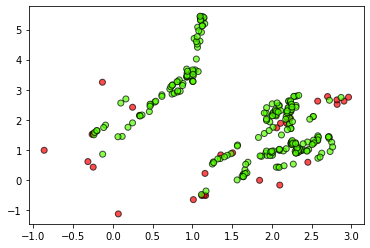

In [109]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.7567045179995168
F1-score [0.86150461 0.        ]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      9396
           1       0.00      0.00      0.00      3021

    accuracy                           0.76     12417
   macro avg       0.38      0.50      0.43     12417
weighted avg       0.57      0.76      0.65     12417



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


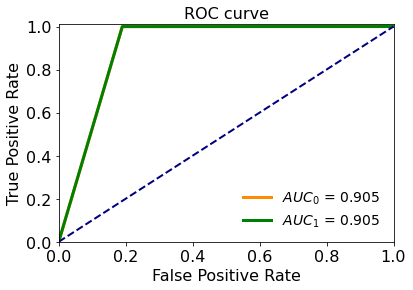

In [110]:
clf_cnn = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf_cnn.fit(X_res, y_res)

y_pred = clf_cnn.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

y_score = clf_cnn.predict_proba(test_features)
fpr, tpr, _ = roc_curve(test_target, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Oversampling

#### RandomOverSampler

In [123]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Partitioned and ROS Oversampled dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s\n' % round(y_res.mean(),2))

Partitioned and ROS Oversampled dataset Counter({0: 5772, 1: 5772})
Share of Occupieds 0.5



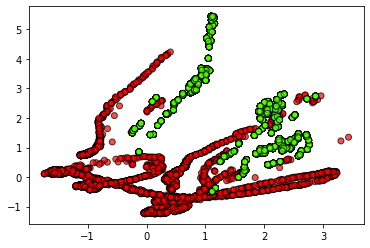

In [125]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.7567045179995168
F1-score [0.86150461 0.        ]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      9396
           1       0.00      0.00      0.00      3021

    accuracy                           0.76     12417
   macro avg       0.38      0.50      0.43     12417
weighted avg       0.57      0.76      0.65     12417



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


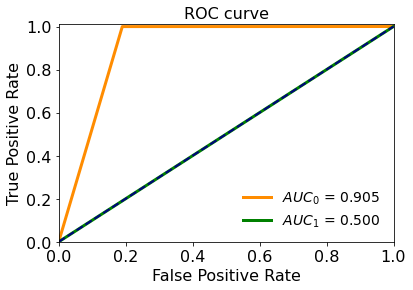

In [127]:
clf_ros = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf_ros.fit(X_res, y_res)

y_pred = clf_ros.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

y_score = clf_ros.predict_proba(test_features)
fpr, tpr, _ = roc_curve(test_target, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [119]:
1-test_target.mean()

0.7567045179995168

#### SMOTE

In [128]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Partitioned and SMOTEd dataset %s' % Counter(pd.Series(y_res)))
print('Share of Occupieds %s\n' % round(y_res.mean(),2))

Partitioned and SMOTEd dataset Counter({0: 5772, 1: 5772})
Share of Occupieds 0.5



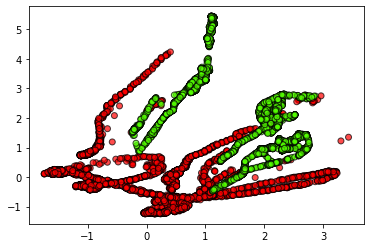

In [129]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.8561649351695256
F1-score [0.89499059 0.77178635]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      9396
           1       0.63      1.00      0.77      3021

    accuracy                           0.86     12417
   macro avg       0.81      0.90      0.83     12417
weighted avg       0.91      0.86      0.87     12417



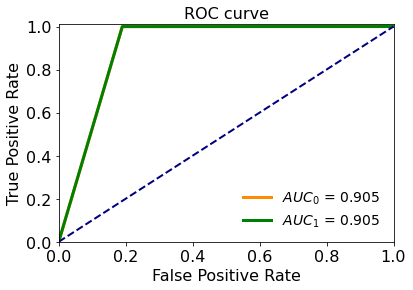

In [130]:
clf_smote = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf_smote.fit(X_res, y_res)

y_pred = clf_smote.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

y_score = clf_smote.predict_proba(test_features)
fpr, tpr, _ = roc_curve(test_target, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [131]:
# (pd.concat([pd.DataFrame(test_target), pd.DataFrame(y_pred, columns=["prediction"])], axis=1)
# ).to_csv("C:/Users/xhuli/Desktop/classification_smoted.csv")

#### Class Weight

Accuracy 0.8561649351695256
F1-score [0.89499059 0.77178635]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89      9396
           1       0.63      1.00      0.77      3021

    accuracy                           0.86     12417
   macro avg       0.81      0.90      0.83     12417
weighted avg       0.91      0.86      0.87     12417



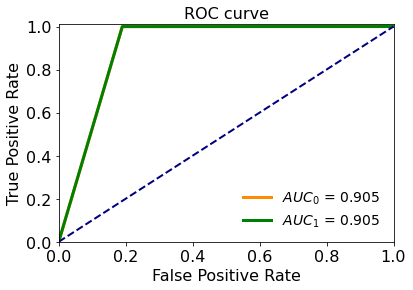

In [140]:
clf_cw = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:1, 1: 5}, random_state=42)
clf_cw.fit(X_train, y_train)

y_pred = clf_cw.predict(test_features)

print('Accuracy %s' % accuracy_score(test_target, y_pred))
print('F1-score %s' % f1_score(test_target, y_pred, average=None))
print(classification_report(test_target, y_pred))

y_score = clf_cw.predict_proba(test_features)
fpr, tpr, _ = roc_curve(test_target, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Automatically created module for IPython interactive environment


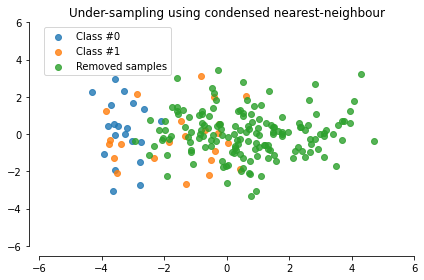

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.under_sampling import CondensedNearestNeighbour

print(__doc__)

# Generate the dataset
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=200, random_state=10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour(return_indices=True)
X_resampled, y_resampled, idx_resampled = cnn.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
plt.scatter(X_res_vis[idx_class_0, 0], X_res_vis[idx_class_0, 1],
            alpha=.8, label='Class #0')
plt.scatter(X_res_vis[~idx_class_0, 0], X_res_vis[~idx_class_0, 1],
            alpha=.8, label='Class #1')
plt.scatter(X_vis[idx_samples_removed, 0], X_vis[idx_samples_removed, 1],
            alpha=.8, label='Removed samples')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])

plt.title('Under-sampling using condensed nearest-neighbour')
plt.legend()
plt.tight_layout()
plt.show()

In [105]:
Counter(pd.Series(y_resampled))

Counter({0: 20, 1: 23})